In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.stats as st
import statsmodels.stats.proportion as proportion
import scipy.stats as stats


### Доверительные интервалы

# 1
Диаграмма зависимости количества проданной пиццы от дня недели

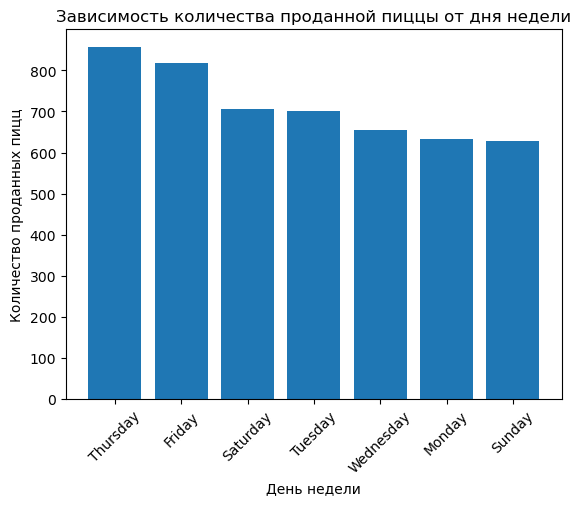

День недели с наибольшим количеством проданных пицц: Thursday
День недели с наименьшим количеством проданных пицц: Sunday


In [2]:
df = pd.read_csv('../datasets/pizza.csv', sep=';')
df['lead_time'] = pd.to_datetime(df['lead_time'])
df['day_of_week'] = df['lead_time'].dt.day_name()

pizza_count = df['day_of_week'].value_counts()

plt.bar(pizza_count.index, pizza_count.values)
plt.xlabel('День недели')
plt.ylabel('Количество проданных пицц')
plt.title('Зависимость количества проданной пиццы от дня недели')
plt.xticks(rotation=45)
plt.show()

max_pizza_day = pizza_count.idxmax()
min_pizza_day = pizza_count.idxmin()
print(f'День недели с наибольшим количеством проданных пицц: {max_pizza_day}')
print(f'День недели с наименьшим количеством проданных пицц: {min_pizza_day}')

# 2
### Считаем среднее, медианное, максимальное и минимальное время приготовления пиццы. 

In [3]:
df['cook_time'] = pd.to_datetime(df['lead_time']) - pd.to_datetime(df['order_time'], format='%H:%M:%S')
df['cook_time'] = df['cook_time'].dt.seconds

print(f'Среднее время приготовления пиццы: {round(df["cook_time"].mean())} секунд')
print(f'Медианное время приготовления пиццы: {round(df["cook_time"].median())} секунд')
print(f'Максимальное время приготовления пиццы: {round(df["cook_time"].max())} секунд')
print(f'Минимальное время приготовления пиццы: {round(df["cook_time"].min())} секунд')

Среднее время приготовления пиццы: 1007 секунд
Медианное время приготовления пиццы: 1006 секунд
Максимальное время приготовления пиццы: 1609 секунд
Минимальное время приготовления пиццы: 444 секунд


## 3
### Строим 95% доверительный интервал для среднего времени приготовления пиццы в **секундах**.

In [4]:
# стандартное отклонение
std_otk = st.sem(df['cook_time'], ddof=1)
mean_cook = df['cook_time'].mean()          # среднее отклонение
dl=len(df['cook_time'])
#print(std_otk, dl)
st_int=st.t.interval(0.95 , dl, mean_cook, std_otk)
print('Доверительный интервал: ',[round(i) for i in st_int])

Доверительный интервал:  [1002, 1012]


# 4
### Оптимизация меню
Поскольку теперь, время изготовления пицыы будет влиять на её стоимость, найдём пиццу у которой верхняя граница доверительного интервала её изготовления 
самая высокая.
> Среди пицц, у которых за все время заказывали более 100 штук

In [5]:
pizza_count = df['pizza_name'].value_counts()
pizza_pop = pizza_count[pizza_count > 100].index

pizza_top = df[df['pizza_name'].isin(pizza_pop)]

pizza_spis = pizza_top.groupby('pizza_name')['cook_time'].agg(['count', 'mean', 'std'])

pizza_spis['se'] = pizza_spis['std'] / np.sqrt(pizza_spis['count'])
pizza_spis['high_border'] = pizza_spis['mean'] + 1.96 * pizza_spis['se']  # 1.96 corresponds to 95% confidence level

# нахождение пиццы с самой высокой верхней границей доверительного интервала
pizza_name_top = pizza_spis['high_border'].idxmax()

print('Cамая высокая верхняя граница доверительного интервала у', pizza_name_top)

Cамая высокая верхняя граница доверительного интервала у The Italian Vegetables Pizza


# 5
Находим пиццу с самым нестабильным временем приготовления.
(с самым широким доверительным интервалом)
> Среди пицц, у которых за все время заказывали более 100 штук

In [6]:
pizza_spis['top_se'] = pizza_spis['mean'] + pizza_spis['se']
pizza_spis['botton_se'] = pizza_spis['mean'] - pizza_spis['se']
pizza_spis['mas_se'] =(pizza_spis['top_se'] - pizza_spis['botton_se'])
print('Самый широкий доверительный интервал у ',pizza_spis['mas_se'].idxmax())

Самый широкий доверительный интервал у  The Chicken Alfredo Pizza


## AB тестирование

# 6
В качестве нулевой гипотезы (H0) выберем, что старый баннер лучше нового.  В качестве альтернативной гипотезы (H1) выберем, 
что новый баннер лучше старого. Построй 95% доверительный интервал для доли каждого из баннеров, используя метод 
Проверяем пересечение интервалов

In [7]:
df_click = pd.read_csv('../datasets/click.csv')


clicks_a = df_click['banner_a'].sum()
shows_a = len(df_click) - clicks_a

clicks_b = df_click['banner_b'].sum()
shows_b = len(df_click) - clicks_b

ci_a = proportion.proportion_confint(clicks_a, shows_a, alpha=0.05)
ci_b = proportion.proportion_confint(clicks_b, shows_b, alpha=0.05)

if ci_a[0] <= ci_b[1] and ci_b[0] <= ci_a[1]:
    print('Доверительные интервалы пересекаются',  [round(i,3) for i in ci_a],' и ', [round(i,3) for i in ci_b])
else:
    print('Доверительные интервалы не пересекаются')

Доверительные интервалы пересекаются [0.026, 0.051]  и  [0.041, 0.071]


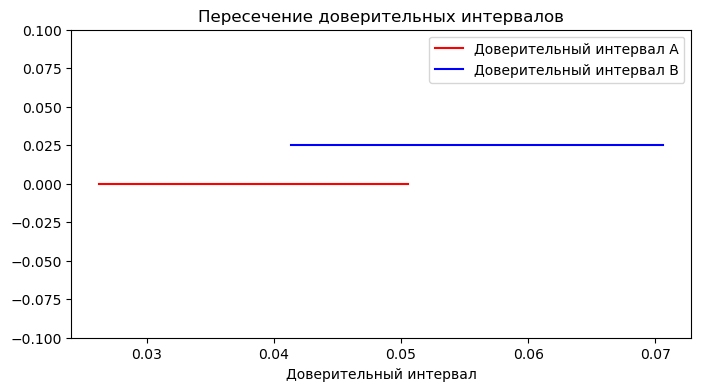

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(ci_a, [0, 0], color='red', label='Доверительный интервал A')
plt.plot(ci_b, [0.025, 0.025], color='blue', label='Доверительный интервал B')
plt.ylim(-0.1, 0.1)
plt.xlabel('Доверительный интервал')
plt.title('Пересечение доверительных интервалов')
plt.legend()
plt.show()

## 7
Для более детальной оценки строим 95% доверительный интервал для разности двух долей.


Левая и правая границы доверительного интервала рассчитываются по формулам:
$$p_a - p_b \pm z * \sqrt{\frac{p_a(1 - p_a)}{n_a} + \frac{p_b(1 - p_b)}{n_b}}$$
Где

$p_a = \frac{n_{like(a)}}{n_{a}}$,

$p_b = \frac{n_{like(b)}}{n_{b}}$,

$z = 1-\frac{\alpha}{2}$ (используй scipy.stats.norm.ppf)

$n_a$ - общее количество кликов по баннеру а

$n_b$ - общее количество кликов по баннеру b

$n_{like(a)}$ - количество лайков по баннеру а

$n_{like(b)}$ - количество лайков по баннеру b

In [9]:

n =n_a = n_b = len(df_click)
p_a = clicks_a / n
p_b = clicks_b / n

z = stats.norm.ppf(1 - 0.05/2)

se = ((p_a * (1 - p_a) / n) + (p_b * (1 - p_b) / n))**0.5

diff = p_a - p_b
ci_left = p_a - p_b - z * se
ci_right = p_a - p_b + z * se

print(f"95% доверительный интервал для двух долей: [{ci_left:.5f}, {ci_right:.5f}]")

95% доверительный интервал для двух долей: [-0.03416, 0.00216]


# 8
АБ-тест. 
Какой баннер лучше? H0 - Старый баннер или H1 - новый баннер.

$$Z({X_1, X_2}) =  \frac{p_a - p_b}{\sqrt{P(1 - P)(\frac{1}{n_a} + \frac{1}{n_b})}}$$
$$P = \frac{p_a{n_a} + p_b{n_b}}{{n_a} + {n_b}} $$

$p_a, p_b = \frac{∑кликов}{n}$, n - общее количество кликов по баннеру

$n_a$ - общее количество кликов по баннеру а

$n_b$ - общее количество кликов по баннеру b

In [10]:
def z_stat(sample1, sample2):
    n_a = len(sample1)
    n_b = len(sample2)

    p_a = float(sum(sample1)) / n_a
    p_b = float(sum(sample2)) / n_b 
    P = float(p_a * n_a + p_b * n_b) / (n_a + n_b)
  
    return (p_a - p_b) / np.sqrt(P * (1 - P) * (1. / n_a + 1. / n_b))

In [11]:
sample_a = df_click['banner_a']
sample_b = df_click['banner_b']

z_value = z_stat(sample_a, sample_b)
print(f'z_value {z_value}')

p_value = stats.norm.sf(abs(z_value))
print(f'p_value {p_value}')

if p_value < 0.05:
    if z_value > 0:
        print("Старый баннер больше нравится пользователям")
    else:
        print("Новый баннер больше нравится пользователям")
else:
    print("Нет  разницы")

z_value -1.7258261378415294
p_value 0.042189348005533284
Новый баннер больше нравится пользователям


## Обзор Корреляции Пирсона и Спирмена

# 9
 По сгенерированным выборкам посчитаем коррелицию Пирсона и Спирмена для выборок `x-y1`, `x-y2`, `x-y3`.


In [12]:
x = np.linspace(-10,10,100)
y1 = x ** 2
y2 = -x **2
y3 = np.log(x ** 2 + 1)

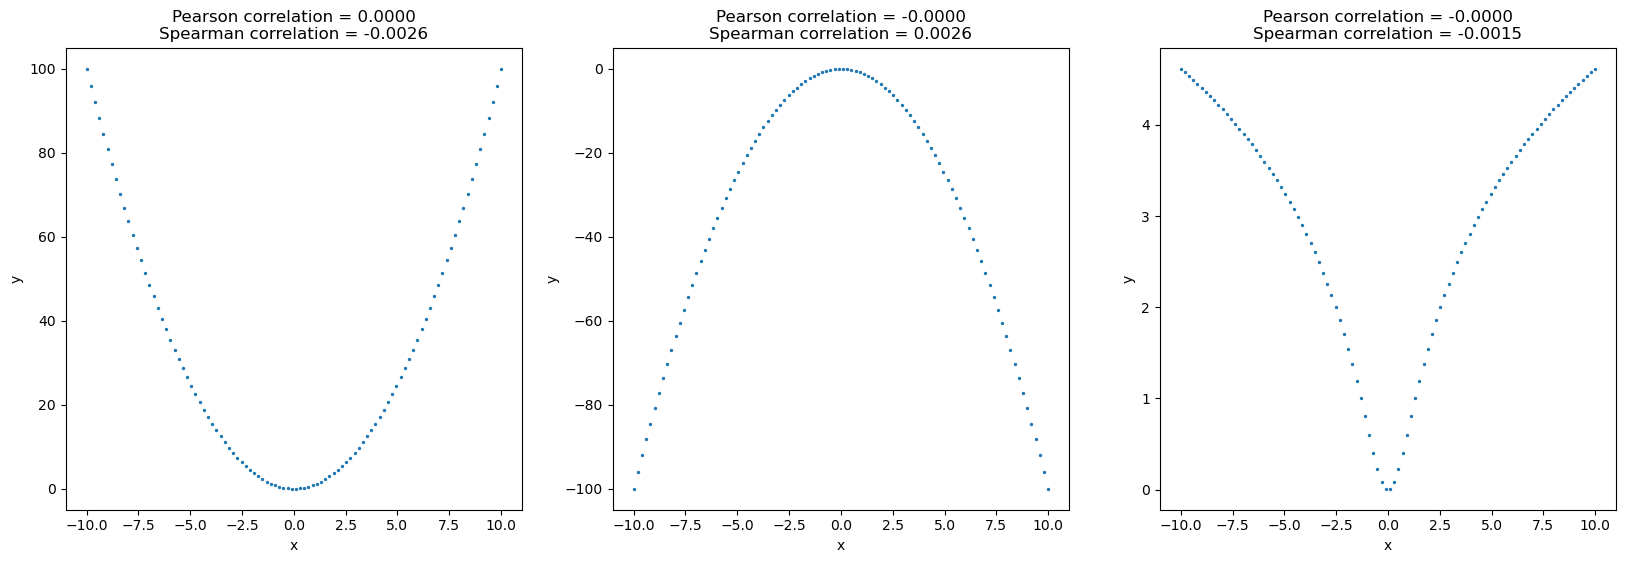


Корреляция Пирсона измеряет параметрическую зависимость между данными, а корреляция Спирмена - ранговую зависимость.
Низкое значение коэффициентов говорит о малой связи между x и y величинами.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

x = np.linspace(-10, 10, 100)
y1 = x ** 2
y2 = -x ** 2
y3 = np.log(x ** 2 + 1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, y in enumerate([y1, y2, y3]):
    ax[i].scatter(x, y, s=2)
    ax[i].set(xlabel='x', ylabel='y')
    ax[i].set_title(f"Pearson correlation = {np.corrcoef(x, y)[0, 1]:.4f}\nSpearman correlation = {stats.spearmanr(x, y).correlation:.4f}")

plt.show()

print('\nКорреляция Пирсона измеряет параметрическую зависимость между данными, а корреляция Спирмена - ранговую зависимость.')
print('Низкое значение коэффициентов говорит о малой связи между x и y величинами.')

# 10
Проверка устойчивости к выбросам кореляций Спирмена и Пирсона

In [14]:
step = np.linspace(-10, 0, 1000)
x = -step + np.random.randn(1000) * 0.2
y = step + np.random.randn(1000)* 0.2

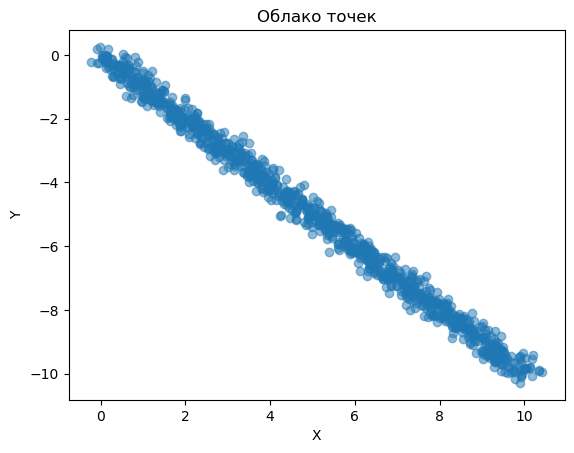

Коэффициент корреляции Пирсона: -0.9956
Коэффициент корреляции Спирмана: -0.9958


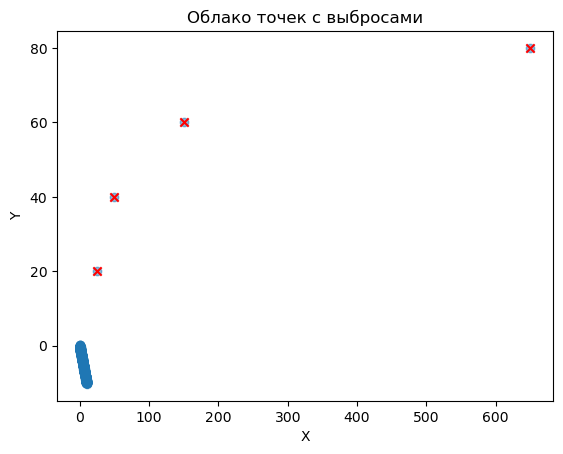

Коэффициент корреляции Пирсона с выбросами: 0.5819
Коэффициент корреляции Спирмана с выбросами: -0.9720


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

np.random.seed(0)

step = np.linspace(-10, 0, 1000)
x = -step + np.random.randn(1000) * 0.2
y = step + np.random.randn(1000) * 0.2

# Построение облака точек
plt.scatter(x, y, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Облако точек')
plt.show()

# Расчет коэффициентов корреляции
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)

print(f'Коэффициент корреляции Пирсона: {pearson_corr:.4f}')
print(f'Коэффициент корреляции Спирмана: {spearman_corr:.4f}')

# Передвижение точек
outliers_x = [25, 50, 150, 650]
outliers_y = [20, 40, 60, 80]

x_with_outliers = np.concatenate((x, outliers_x))
y_with_outliers = np.concatenate((y, outliers_y))

# Построение облака точек с выбросами
plt.scatter(x_with_outliers, y_with_outliers, alpha=0.5)
plt.scatter(outliers_x, outliers_y, color='red', marker='x')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Облако точек с выбросами')
plt.show()

# Расчет коэффициентов корреляции с выбросами
pearson_corr_outliers, _ = pearsonr(x_with_outliers, y_with_outliers)
spearman_corr_outliers, _ = spearmanr(x_with_outliers, y_with_outliers)

print(f'Коэффициент корреляции Пирсона с выбросами: {pearson_corr_outliers:.4f}')
print(f'Коэффициент корреляции Спирмана с выбросами: {spearman_corr_outliers:.4f}')

